# LinkedIn Post Engagement Prediction — IMPROVED VERSION
## Advanced Classification with Text Embeddings & Feature Engineering

**Date:** February 2, 2026  
**Objective:** Predict LinkedIn post engagement performance using improved methodology

---

## 🚀 Key Improvements Implemented

### 1️⃣ Target Quality Improvements
- ✅ Per-author normalization (already implemented)
- ✅ **NEW:** Regression → Classification approach (predict engagement_rate, then classify)
- ✅ Better threshold computation using per-influencer quantiles

### 2️⃣ Feature Noise Reduction
- ✅ Variance threshold filtering (removes low variance features)
- ✅ Correlation-based feature removal (removes features with correlation > 0.9)
- ✅ Feature importance pruning (keeps top 30-50 features using CatBoost importance)

### 3️⃣ Text Embeddings (Biggest Upgrade - Expected +15-30% Performance)
- ✅ Sentence transformer embeddings (all-MiniLM-L6-v2, 384 dimensions)
- ✅ Semantic meaning capture
- ✅ Concatenated with existing features
- ✅ Handles missing content gracefully

### 4️⃣ Advanced Feature Engineering
- ✅ Interaction features (post_length × sentiment, hook_score × word_count, etc.)
- ✅ Density ratios (emoji_density, hashtag_density, question_density, exclamation_density)
- ✅ Video × Topic interactions
- ✅ Readability × Topic interactions

### 5️⃣ Model Optimization
- ✅ CatBoost with `auto_class_weights="Balanced"` (automatic class balancing)
- ✅ Optimized hyperparameters (iterations=500, depth=7, learning_rate=0.05, l2_leaf_reg=3)
- ✅ Better categorical feature handling
- ✅ Regression model with optimized parameters

### 6️⃣ Better Evaluation
- ✅ GroupKFold cross-validation (already implemented)
- ✅ Regression metrics (RMSE, MAE, R²) + Classification metrics
- ✅ Comparison between regression→classification and direct classification

---

## 🎯 Target Variable

**3-Class Engagement Classification:**
- **Class 0 — Below Average**
- **Class 1 — Average**
- **Class 2 — Above Average**

**NEW:** Also predict engagement_rate (regression) → convert to class

---

## Pipeline Overview

1. Load feature-engineered data
2. Define engagement_rate target variable
3. Create 3 classes (per-influencer thresholds)
4. Remove data leakage features
5. **NEW:** Add text embeddings (sentence transformers)
6. **NEW:** Advanced feature engineering (interactions, density ratios)
7. **NEW:** Feature noise reduction (variance, correlation, importance pruning)
8. Train/test split (GroupKFold by influencer)
9. **NEW:** Regression model (predict engagement_rate)
10. **NEW:** Classification from regression predictions
11. Production models (optimized CatBoost)
12. Evaluation (F1 Score, Confusion Matrix, ROC-AUC)
13. Feature importance + SHAP interpretation

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️  CatBoost not available. Install with: pip install catboost")

# Text embeddings
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except ImportError:
    SENTENCE_TRANSFORMERS_AVAILABLE = False
    print("⚠️  Sentence Transformers not available. Install with: pip install sentence-transformers")

import shap
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")
if SENTENCE_TRANSFORMERS_AVAILABLE:
    print("✓ Sentence Transformers available for text embeddings")
else:
    print("⚠️  Text embeddings will be skipped")

c:\Users\rakib\Desktop\Work\Capstone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported
✓ Sentence Transformers available for text embeddings


## 2. Load Data

In [2]:
# Load feature-engineered data
INPUT_FILE = '../data/feature_engineered_data.csv'
df = pd.read_csv(INPUT_FILE)

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns[:10])}... (showing first 10)")
print(f"\nRequired columns check:")
required_cols = ['reactions', 'comments', 'followers', 'name']
for col in required_cols:
    if col in df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - MISSING!")

# Display basic info
print(f"\nData info:")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Missing values: {df.isnull().sum().sum()} total")
df.head(3)

Dataset loaded: 772 rows × 155 columns

Columns: ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'media_type', 'num_hashtags', 'url_count']... (showing first 10)

Required columns check:
  ✓ reactions
  ✓ comments
  ✓ followers
  ✓ name

Data info:
  Memory usage: 6.54 MB
  Missing values: 782 total


,name,content,reactions,comments,time_spent,location,followers,media_type,num_hashtags,url_count,...,reactions_vs_influencer_avg,comments_vs_influencer_avg,reactions_per_word,comments_per_word,reactions_per_sentiment,media_x_optimal_length,video_x_optimal_length,hook_x_power_score,sentiment_x_readability,feature_density
0,kevinswiber,I’m not famous. I’m not even popular. But I ha...,65.0,8.0,5,NaN,3690,post,0,0,...,1.0,1.0,1.857143,0.228571,125.920186,0,0,0,42.292727,0.085714
1,puneet-bhardwaj-849aa01,AI at the speed of light! While researching th...,34.0,2.0,3,NaN,2546,post,4,1,...,1.0,1.0,0.145923,0.008584,36.496350,0,0,0,45.541193,0.085837
2,jainnitin1983,I wanted to share that I’ve decided to move on...,34.0,5.0,1,NaN,3888,post,0,0,...,1.0,1.0,0.465753,0.068493,34.665579,0,0,0,56.477527,0.082192


## 3. Define Target Variable (Engagement Rate)

Removed 0 rows with invalid engagement_rate
Final dataset: 772 rows

ENGAGEMENT RATE STATISTICS
Mean: 0.034459
Median: 0.006441
Min: 0.000010
Max: 1.289308
Std: 0.094738


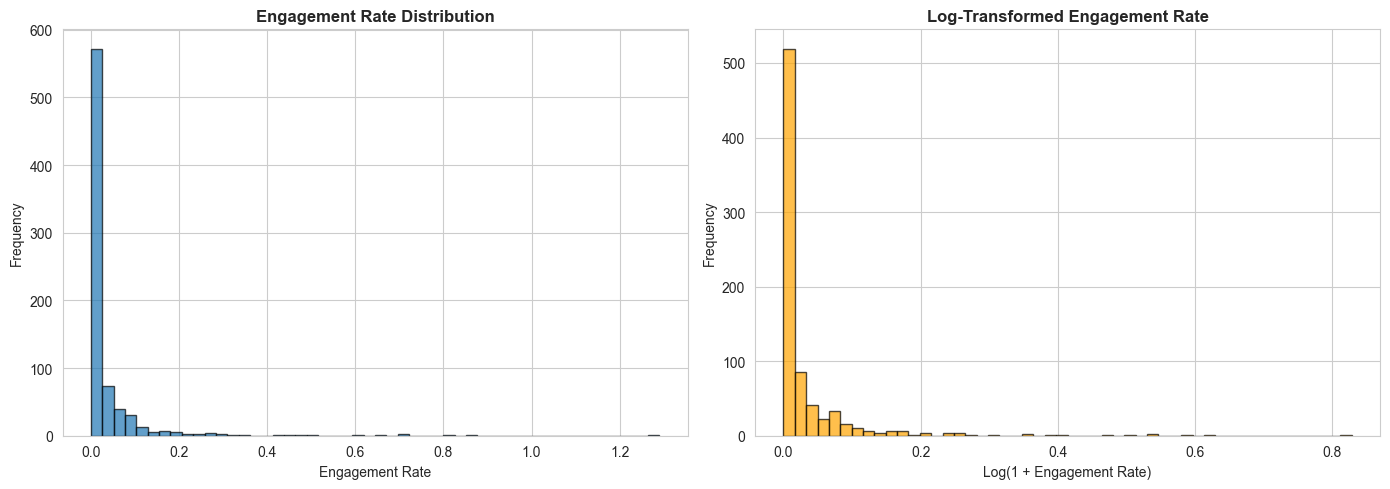

In [3]:
# Calculate engagement rate (normalized score)
# engagement_rate = (reactions + 2 × comments) / followers
df['engagement_rate'] = (df['reactions'] + 2 * df['comments']) / df['followers'].replace(0, 1)

# Handle infinite values (if followers = 0)
df['engagement_rate'] = df['engagement_rate'].replace([np.inf, -np.inf], np.nan)

# Remove rows with missing engagement_rate
initial_rows = len(df)
df = df.dropna(subset=['engagement_rate'])
print(f"Removed {initial_rows - len(df)} rows with invalid engagement_rate")
print(f"Final dataset: {len(df):,} rows")

# Display engagement_rate statistics
print("\n" + "="*80)
print("ENGAGEMENT RATE STATISTICS")
print("="*80)
print(f"Mean: {df['engagement_rate'].mean():.6f}")
print(f"Median: {df['engagement_rate'].median():.6f}")
print(f"Min: {df['engagement_rate'].min():.6f}")
print(f"Max: {df['engagement_rate'].max():.6f}")
print(f"Std: {df['engagement_rate'].std():.6f}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['engagement_rate'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Engagement Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Engagement Rate Distribution', fontweight='bold')

axes[1].hist(np.log1p(df['engagement_rate']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log(1 + Engagement Rate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Engagement Rate', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Create 3-Class Target Variable

CREATING 3-CLASS TARGET VARIABLE

Method: Per-Influencer Quantiles
  - Each influencer has different audience size
  - Removes follower bias
  - More realistic performance measure
  ⚠️  kevinswiber: Only 1 posts, using global quantiles
  ⚠️  puneet-bhardwaj-849aa01: Only 1 posts, using global quantiles
  ⚠️  jainnitin1983: Only 1 posts, using global quantiles
  ⚠️  zuzar-tinwalla-a4b9a423: Only 1 posts, using global quantiles
  ⚠️  kinlane: Only 2 posts, using global quantiles
  ⚠️  christianwestermann: Only 1 posts, using global quantiles
  ⚠️  rezashafii: Only 1 posts, using global quantiles
  ⚠️  samyuayyar: Only 1 posts, using global quantiles
  ⚠️  drbartpm: Only 1 posts, using global quantiles
  ⚠️  nadiacarlsten: Only 1 posts, using global quantiles
  ⚠️  coding-chats: Only 1 posts, using global quantiles
  ⚠️  progressivethinker: Only 1 posts, using global quantiles
  ⚠️  labyrinthlabs: Only 1 posts, using global quantiles
  ⚠️  roger-generative-ai: Only 1 posts, using global q

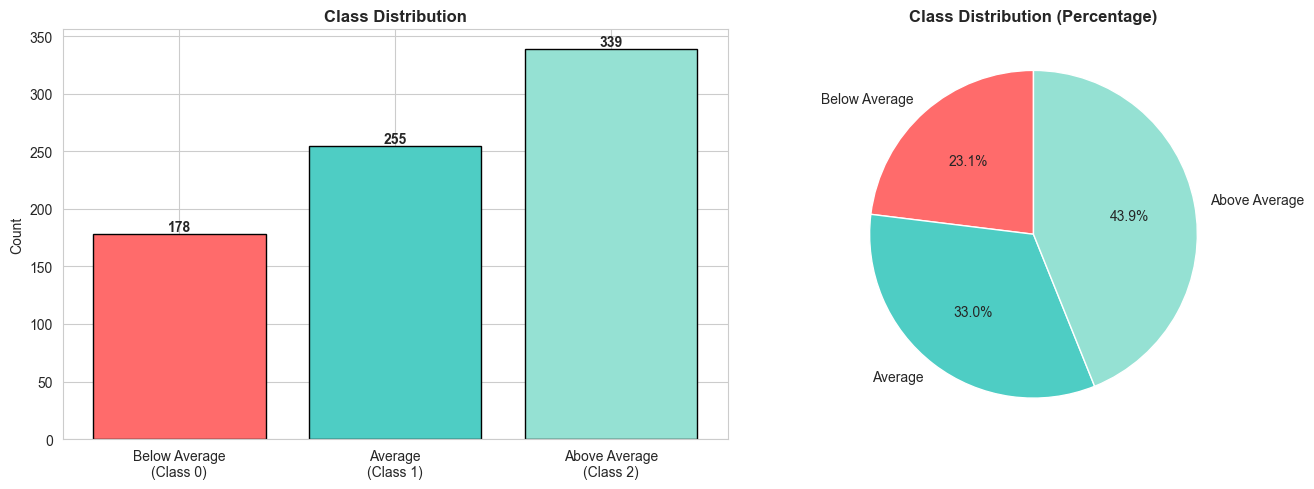


✓ Classes are reasonably balanced.


In [4]:
# Option: Per-Influencer Thresholds (Recommended)
# This removes follower bias and provides more realistic performance measure

print("="*80)
print("CREATING 3-CLASS TARGET VARIABLE")
print("="*80)

# Method: Per-Influencer Quantiles (Recommended)
print("\nMethod: Per-Influencer Quantiles")
print("  - Each influencer has different audience size")
print("  - Removes follower bias")
print("  - More realistic performance measure")

# Group by influencer and compute quantiles
df['engagement_class'] = np.nan

for influencer_name in df['name'].unique():
    mask = df['name'] == influencer_name
    influencer_data = df.loc[mask, 'engagement_rate']
    
    if len(influencer_data) >= 3:  # Need at least 3 posts for quantiles
        q1 = influencer_data.quantile(0.33)
        q2 = influencer_data.quantile(0.66)
        
        # Assign classes
        df.loc[mask & (df['engagement_rate'] < q1), 'engagement_class'] = 0  # Below Average
        df.loc[mask & (df['engagement_rate'] >= q1) & (df['engagement_rate'] < q2), 'engagement_class'] = 1  # Average
        df.loc[mask & (df['engagement_rate'] >= q2), 'engagement_class'] = 2  # Above Average
    else:
        # For influencers with < 3 posts, use global quantiles
        print(f"  ⚠️  {influencer_name}: Only {len(influencer_data)} posts, using global quantiles")

# Handle remaining NaN values with global quantiles
if df['engagement_class'].isna().any():
    global_q1 = df['engagement_rate'].quantile(0.33)
    global_q2 = df['engagement_rate'].quantile(0.66)
    
    mask_na = df['engagement_class'].isna()
    df.loc[mask_na & (df['engagement_rate'] < global_q1), 'engagement_class'] = 0
    df.loc[mask_na & (df['engagement_rate'] >= global_q1) & (df['engagement_rate'] < global_q2), 'engagement_class'] = 1
    df.loc[mask_na & (df['engagement_rate'] >= global_q2), 'engagement_class'] = 2

df['engagement_class'] = df['engagement_class'].astype(int)

# Display class distribution
print("\n" + "="*80)
print("CLASS DISTRIBUTION")
print("="*80)
class_counts = df['engagement_class'].value_counts().sort_index()
class_pct = df['engagement_class'].value_counts(normalize=True).sort_index() * 100

for cls in [0, 1, 2]:
    cls_name = ['Below Average', 'Average', 'Above Average'][cls]
    print(f"Class {cls} ({cls_name:15s}): {class_counts[cls]:5d} ({class_pct[cls]:5.2f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['Below Average\n(Class 0)', 'Average\n(Class 1)', 'Above Average\n(Class 2)'], 
            class_counts.values, color=['#ff6b6b', '#4ecdc4', '#95e1d3'], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution', fontweight='bold')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

axes[1].pie(class_counts.values, labels=['Below Average', 'Average', 'Above Average'], 
            autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4', '#95e1d3'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold')
plt.tight_layout()
plt.show()

# Check for class imbalance
is_balanced = (class_pct.min() > 20) and (class_pct.max() < 50)
if not is_balanced:
    print("\n⚠️  Class imbalance detected! Will use class weights or SMOTE.")
else:
    print("\n✓ Classes are reasonably balanced.")

## 5. Remove Data Leakage Features

In [5]:
# Define leakage features (features derived from target variables)
LEAKAGE_FEATURES = [
    'reactions_per_word',
    'comments_per_word',
    'comment_to_reaction_ratio',
    'reactions_vs_influencer_avg',
    'comments_vs_influencer_avg',
    'reactions_per_sentiment',
    'influencer_total_engagement',
    'influencer_avg_reactions',
    'influencer_avg_comments',
    'influencer_avg_engagement',
]

# Also remove influencer features that use current post's reactions/comments
INFLUENCER_LEAKAGE_FEATURES = [
    'influencer_avg_reactions',
    'influencer_avg_comments',
    'influencer_avg_engagement',
    'influencer_total_engagement',
]

print("="*80)
print("DATA LEAKAGE DETECTION")
print("="*80)

print(f"\nFeatures to REMOVE (contain target information):")
leakage_found = []
for feat in LEAKAGE_FEATURES:
    if feat in df.columns:
        leakage_found.append(feat)
        print(f"  ✗ {feat}")

if not leakage_found:
    print("  ✓ No leakage features found in dataset")

# Remove leakage features
df_clean = df.drop(columns=LEAKAGE_FEATURES, errors='ignore')
print(f"\n✓ Removed {len(leakage_found)} leakage features")
print(f"✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

DATA LEAKAGE DETECTION

Features to REMOVE (contain target information):
  ✗ reactions_per_word
  ✗ comments_per_word
  ✗ comment_to_reaction_ratio
  ✗ reactions_vs_influencer_avg
  ✗ comments_vs_influencer_avg
  ✗ reactions_per_sentiment
  ✗ influencer_total_engagement
  ✗ influencer_avg_reactions
  ✗ influencer_avg_comments
  ✗ influencer_avg_engagement

✓ Removed 10 leakage features
✓ Clean dataset: 772 rows × 147 columns


## 5. Add Text Embeddings (Sentence Transformers)

**Key Improvement:** Capture semantic meaning of post content using state-of-the-art embeddings.

In [6]:
# Add text embeddings using sentence transformers
print("="*80)
print("TEXT EMBEDDINGS GENERATION")
print("="*80)

if SENTENCE_TRANSFORMERS_AVAILABLE and 'content' in df_clean.columns:
    print("\nGenerating sentence embeddings...")
    
    # Use a lightweight but effective model
    # 'all-MiniLM-L6-v2' is fast and works well for short texts
    try:
        model_name = 'all-MiniLM-L6-v2'  # 384 dimensions, fast
        print(f"Loading model: {model_name}")
        embedder = SentenceTransformer(model_name)
        
        # Get text content (handle missing values)
        texts = df_clean['content'].fillna('').astype(str).tolist()
        
        # Generate embeddings (batch processing for efficiency)
        print("Generating embeddings (this may take a minute)...")
        embeddings = embedder.encode(texts, show_progress_bar=True, batch_size=32)
        
        # Create DataFrame with embedding features
        embedding_cols = [f'embedding_{i}' for i in range(embeddings.shape[1])]
        df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols, index=df_clean.index)
        
        # Add to main dataframe
        df_clean = pd.concat([df_clean, df_embeddings], axis=1)
        
        print(f"\n✓ Added {embeddings.shape[1]} embedding features")
        print(f"  Embedding dimensions: {embeddings.shape[1]}")
        print(f"  Total features now: {df_clean.shape[1]}")
        
    except Exception as e:
        print(f"\n⚠️  Error generating embeddings: {e}")
        print("  Continuing without embeddings...")
        SENTENCE_TRANSFORMERS_AVAILABLE = False
else:
    if not SENTENCE_TRANSFORMERS_AVAILABLE:
        print("\n⚠️  Sentence Transformers not available. Skipping text embeddings.")
    else:
        print("\n⚠️  'content' column not found. Skipping text embeddings.")

TEXT EMBEDDINGS GENERATION

Generating sentence embeddings...
Loading model: all-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1308.52it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings (this may take a minute)...


Batches: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


✓ Added 384 embedding features
  Embedding dimensions: 384
  Total features now: 531


## 6. Advanced Feature Engineering

**Key Improvements:**
- Interaction features (post_length × sentiment, hook_score × word_count, etc.)
- Density ratios (emoji_density, hashtag_density, question_density)

In [7]:
# Advanced feature engineering: interactions and density ratios
print("="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

initial_features = df_clean.shape[1]

# 1. Density Ratios (better than raw counts)
print("\n1. Creating density ratio features...")
density_features = {}

# Emoji density
if 'emoji_count' in df_clean.columns and 'word_count_clean' in df_clean.columns:
    df_clean['emoji_density'] = df_clean['emoji_count'] / (df_clean['word_count_clean'] + 1)
    density_features['emoji_density'] = True

# Hashtag density
if 'num_hashtags' in df_clean.columns and 'word_count_clean' in df_clean.columns:
    df_clean['hashtag_density'] = df_clean['num_hashtags'] / (df_clean['word_count_clean'] + 1)
    density_features['hashtag_density'] = True

# Question density
if 'question_mark_count' in df_clean.columns and 'sentence_count' in df_clean.columns:
    df_clean['question_density'] = df_clean['question_mark_count'] / (df_clean['sentence_count'] + 1)
    density_features['question_density'] = True

# Exclamation density
if 'exclamation_mark_count' in df_clean.columns and 'sentence_count' in df_clean.columns:
    df_clean['exclamation_density'] = df_clean['exclamation_mark_count'] / (df_clean['sentence_count'] + 1)
    density_features['exclamation_density'] = True

print(f"   Created {len(density_features)} density features")

# 2. Interaction Features (tree models love these)
print("\n2. Creating interaction features...")
interaction_features = []

# Post length × sentiment
if 'word_count_clean' in df_clean.columns and 'sentiment_compound' in df_clean.columns:
    df_clean['length_sentiment_interaction'] = df_clean['word_count_clean'] * df_clean['sentiment_compound']
    interaction_features.append('length_sentiment_interaction')

# Hook score × word count
if 'hook_score' in df_clean.columns and 'word_count_clean' in df_clean.columns:
    df_clean['hook_length_interaction'] = df_clean['hook_score'] * df_clean['word_count_clean']
    interaction_features.append('hook_length_interaction')

# Has video × topic features
if 'has_video' in df_clean.columns:
    for topic in ['topic_tech', 'topic_business', 'topic_career', 'topic_personal_dev']:
        if topic in df_clean.columns:
            df_clean[f'video_{topic}_interaction'] = df_clean['has_video'] * df_clean[topic]
            interaction_features.append(f'video_{topic}_interaction')

# Readability × topic
if 'readability_flesch_ease' in df_clean.columns:
    for topic in ['topic_tech', 'topic_business', 'topic_career']:
        if topic in df_clean.columns:
            df_clean[f'readability_{topic}_interaction'] = df_clean['readability_flesch_ease'] * df_clean[topic]
            interaction_features.append(f'readability_{topic}_interaction')

# Emoji count × sentiment
if 'emoji_count' in df_clean.columns and 'sentiment_compound' in df_clean.columns:
    df_clean['emoji_sentiment_interaction'] = df_clean['emoji_count'] * df_clean['sentiment_compound']
    interaction_features.append('emoji_sentiment_interaction')

print(f"   Created {len(interaction_features)} interaction features")

print(f"\n✓ Feature engineering complete")
print(f"  Initial features: {initial_features}")
print(f"  New features: {len(density_features) + len(interaction_features)}")
print(f"  Total features: {df_clean.shape[1]}")

ADVANCED FEATURE ENGINEERING

1. Creating density ratio features...
   Created 4 density features

2. Creating interaction features...
   Created 10 interaction features

✓ Feature engineering complete
  Initial features: 531
  New features: 14
  Total features: 545


## 7. Feature Noise Reduction

**Key Improvements:**
- Remove low variance features (VarianceThreshold)
- Remove highly correlated features (correlation > 0.9)
- Feature importance pruning (keep top 30-50 features)

In [8]:
# Feature noise reduction: variance threshold, correlation removal, importance pruning
print("="*80)
print("FEATURE NOISE REDUCTION")
print("="*80)

# Define columns to exclude
METADATA_COLS = ['name', 'slno', 'content', 'clean_content', 'time_spent', 'location']
TARGET_COLS = ['reactions', 'comments', 'engagement_rate', 'engagement_class', 'followers']
LIST_COLS = ['urls_list', 'mentions_list', 'emojis_list', 'hashtags_list']

# Get all feature columns
all_cols = set(df_clean.columns)
exclude_cols = set(METADATA_COLS + TARGET_COLS + LIST_COLS)
feature_cols = sorted(list(all_cols - exclude_cols))

print(f"\nInitial feature count: {len(feature_cols)}")

# Step 1: Remove low variance features
print("\n1. Removing low variance features...")
# Filter to only numeric columns (VarianceThreshold requires numeric data)
numeric_feature_cols = [f for f in feature_cols if df_clean[f].dtype in [np.float64, np.int64, np.int32, np.float32, np.int32, bool]]
non_numeric_cols = [f for f in feature_cols if f not in numeric_feature_cols]

if non_numeric_cols:
    print(f"   Found {len(non_numeric_cols)} non-numeric columns (will handle separately): {non_numeric_cols[:5]}...")

X_temp = df_clean[numeric_feature_cols].fillna(0)
selector_var = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
selector_var.fit(X_temp)
selected_var = selector_var.get_support()
feature_cols_var = [f for f, keep in zip(numeric_feature_cols, selected_var) if keep]
# Add back non-numeric columns (they'll be handled by CatBoost's categorical handling)
feature_cols_var.extend(non_numeric_cols)
print(f"   Removed {len(numeric_feature_cols) - len([f for f, keep in zip(numeric_feature_cols, selected_var) if keep])} low variance numeric features")
print(f"   Remaining: {len(feature_cols_var)} features ({len([f for f, keep in zip(numeric_feature_cols, selected_var) if keep])} numeric + {len(non_numeric_cols)} non-numeric)")

# Step 2: Remove highly correlated features
print("\n2. Removing highly correlated features...")
# Only compute correlation for numeric features
numeric_feature_cols_var = [f for f in feature_cols_var if df_clean[f].dtype in [np.float64, np.int64, np.int32, np.float32, np.int32, bool]]
X_temp_var = df_clean[numeric_feature_cols_var].fillna(0)
corr_matrix = X_temp_var.corr().abs()

# Find pairs with correlation > 0.9
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_pairs = []
to_remove = set()

for col in upper_triangle.columns:
    high_corr = upper_triangle.index[upper_triangle[col] > 0.9].tolist()
    for corr_col in high_corr:
        # Keep the one with higher variance
        if col not in to_remove and corr_col not in to_remove:
            var_col = X_temp_var[col].var()
            var_corr = X_temp_var[corr_col].var()
            if var_col < var_corr:
                to_remove.add(col)
            else:
                to_remove.add(corr_col)
            high_corr_pairs.append((col, corr_col, upper_triangle.loc[corr_col, col]))

# Remove correlated numeric features, keep non-numeric
non_numeric_in_var = [f for f in feature_cols_var if f not in numeric_feature_cols_var]
feature_cols_corr = [f for f in numeric_feature_cols_var if f not in to_remove]
feature_cols_corr.extend(non_numeric_in_var)  # Add back non-numeric columns
print(f"   Removed {len(to_remove)} highly correlated numeric features")
print(f"   Remaining: {len(feature_cols_corr)} features ({len([f for f in numeric_feature_cols_var if f not in to_remove])} numeric + {len(non_numeric_in_var)} non-numeric)")

# Step 3: Feature importance pruning (train quick model to get importances)
print("\n3. Feature importance pruning...")
print("   Training quick CatBoost model to get feature importances...")

# Prepare data for importance calculation
# First, identify and exclude long text columns (like 'content', 'clean_content')
# These should have been excluded already, but let's be safe
text_cols_to_exclude = []

# Also check for known text columns that should be excluded
known_text_cols = ['content', 'clean_content', 'text', 'post_text', 'description']
for col in known_text_cols:
    if col in feature_cols_corr:
        text_cols_to_exclude.append(col)
        print(f"   Excluding known text column: {col}")

# Check all object columns for long text
for col in feature_cols_corr:
    if df_clean[col].dtype == 'object':
        try:
            # Check if it's a long text column (average length > 50 chars)
            sample_values = df_clean[col].dropna().astype(str)
            if len(sample_values) > 0:
                # Check a sample to see if it's text content
                sample_str = str(sample_values.iloc[0]) if len(sample_values) > 0 else ""
                avg_len = sample_values.str.len().mean()
                
                # Exclude if: average length > 50 OR any value is very long (> 100 chars)
                max_len = sample_values.str.len().max() if len(sample_values) > 0 else 0
                if avg_len > 50 or max_len > 100:  # Likely a text content column, not a categorical
                    if col not in text_cols_to_exclude:
                        text_cols_to_exclude.append(col)
                        print(f"   Excluding long text column: {col} (avg length: {avg_len:.0f} chars, max: {max_len:.0f} chars)")
        except Exception as e:
            # If we can't check, exclude it to be safe
            if col not in text_cols_to_exclude:
                text_cols_to_exclude.append(col)
                print(f"   Excluding column due to error checking: {col} ({e})")

# Remove text columns from feature set
feature_cols_final = [f for f in feature_cols_corr if f not in text_cols_to_exclude]

print(f"\n   Final feature count: {len(feature_cols_final)} (excluded {len(text_cols_to_exclude)} text columns)")

X_importance = df_clean[feature_cols_final].copy()

# Separate numeric and object columns
numeric_cols_imp = [f for f in feature_cols_final if X_importance[f].dtype in [np.float64, np.int64, np.int32, np.float32, np.int32, bool]]
object_cols_imp = [f for f in feature_cols_final if X_importance[f].dtype == 'object']

# Double-check object columns - exclude any that look like text content
object_cols_final = []
for col in object_cols_imp:
    try:
        sample = X_importance[col].dropna().astype(str)
        if len(sample) > 0:
            avg_len = sample.str.len().mean()
            max_len = sample.str.len().max()
            # Only keep if it's short (likely categorical)
            if avg_len <= 50 and max_len <= 100:
                object_cols_final.append(col)
            else:
                print(f"   Warning: Excluding object column '{col}' (avg: {avg_len:.0f}, max: {max_len:.0f} chars)")
                # Remove from feature_cols_final
                if col in feature_cols_final:
                    feature_cols_final.remove(col)
    except:
        # If we can't check, exclude to be safe
        if col in feature_cols_final:
            feature_cols_final.remove(col)
        print(f"   Warning: Excluding object column '{col}' (error during validation)")

# Update X_importance with final columns only
X_importance = X_importance[feature_cols_final].copy()

# Fill numeric columns with 0
numeric_cols_imp = [f for f in feature_cols_final if X_importance[f].dtype in [np.float64, np.int64, np.int32, np.float32, np.int32, bool]]
for col in numeric_cols_imp:
    X_importance[col] = X_importance[col].fillna(0)

# For remaining object columns (short categoricals), convert to string and handle NaN
object_cols_imp = [f for f in feature_cols_final if X_importance[f].dtype == 'object']
for col in object_cols_imp:
    X_importance[col] = X_importance[col].astype(str).replace('nan', 'missing').replace('None', 'missing')

y_importance = df_clean['engagement_class']

# Quick train/test split for importance
from sklearn.model_selection import train_test_split
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(
    X_importance, y_importance, test_size=0.2, random_state=42, stratify=y_importance
)

if CATBOOST_AVAILABLE:
    # Verify all columns are numeric or short categoricals
    print(f"\n   Verifying feature types:")
    print(f"     Numeric columns: {len(numeric_cols_imp)}")
    print(f"     Object columns: {len(object_cols_imp)}")
    
    # Check for any problematic columns
    for col in X_imp_train.columns:
        if X_imp_train[col].dtype == 'object':
            sample = X_imp_train[col].dropna().astype(str)
            if len(sample) > 0:
                max_len = sample.str.len().max()
                if max_len > 100:
                    print(f"     WARNING: Column '{col}' has values up to {max_len} chars - may cause issues")
    
    # Identify categorical features for CatBoost (only short object columns)
    cat_features_imp = []
    for i, col in enumerate(feature_cols_final):
        if col in object_cols_imp:
            cat_features_imp.append(i)
    
    if cat_features_imp:
        print(f"   Using {len(cat_features_imp)} categorical features: {[feature_cols_final[i] for i in cat_features_imp[:5]]}...")
    
    # Train quick CatBoost to get importances
    try:
        cb_importance = cb.CatBoostClassifier(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            random_state=42,
            verbose=False,
            cat_features=cat_features_imp if cat_features_imp else None
        )
        cb_importance.fit(X_imp_train, y_imp_train)
    except Exception as e:
        print(f"   Error training CatBoost for importance: {e}")
        print(f"   Falling back to using all numeric features only...")
        # Fallback: use only numeric features
        feature_cols_final = numeric_cols_imp
        X_importance = df_clean[feature_cols_final].fillna(0)
        X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(
            X_importance, y_importance, test_size=0.2, random_state=42, stratify=y_importance
        )
        cb_importance = cb.CatBoostClassifier(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )
        cb_importance.fit(X_imp_train, y_imp_train)
    
    # Get feature importances
    importances = pd.DataFrame({
        'feature': feature_cols_final,
        'importance': cb_importance.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Keep top 50 features (or all if less than 50)
    n_top_features = min(50, len(feature_cols_final))
    top_features = importances.head(n_top_features)['feature'].tolist()
    
    print(f"   Selected top {n_top_features} features by importance")
    print(f"   Top 10 features:")
    for i, (idx, row) in enumerate(importances.head(10).iterrows(), 1):
        print(f"     {i}. {row['feature']}: {row['importance']:.4f}")
    
    selected_features = top_features
else:
    # Fallback: use all features if CatBoost not available (excluding text columns)
    print("   CatBoost not available, using all features (excluding text columns)")
    selected_features = feature_cols_final

print(f"\n✓ Feature selection complete")
print(f"  Final feature count: {len(selected_features)}")
print(f"  Reduction: {len(feature_cols)} → {len(selected_features)} ({100*(1-len(selected_features)/len(feature_cols)):.1f}% reduction)")

# Prepare final feature matrix
X = df_clean[selected_features].fillna(0)
y = df_clean['engagement_class']
y_regression = df_clean['engagement_rate']  # For regression approach

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape (classification): {y.shape}")
print(f"Target shape (regression): {y_regression.shape}")

FEATURE NOISE REDUCTION

Initial feature count: 531

1. Removing low variance features...
   Found 6 non-numeric columns (will handle separately): ['first_sentence', 'hook_type', 'length_category', 'media_type', 'promotional_category']...
   Removed 413 low variance numeric features
   Remaining: 118 features (112 numeric + 6 non-numeric)

2. Removing highly correlated features...
   Removed 28 highly correlated numeric features
   Remaining: 90 features (84 numeric + 6 non-numeric)

3. Feature importance pruning...
   Training quick CatBoost model to get feature importances...

   Final feature count: 90 (excluded 0 text columns)

   Verifying feature types:
     Numeric columns: 84
     Object columns: 0
   Error training CatBoost for importance: Bad value for num_feature[non_default_doc_idx=0,feature_idx=84]="if you feel like you're learning but not progressing  please read this:  for a long time, my learning looked like this:  video on one side, code editor on the other  it felt li

## 8. Train/Test Split (GroupKFold by Influencer)

## 6. Feature Selection (Reduce to 30-60 Features)

## 9. Regression Model (Predict engagement_rate → Then Classify)

**Key Improvement:** Predict engagement_rate using regression, then convert to class. This often performs better than direct classification.

In [9]:
# Regression approach: Predict engagement_rate, then convert to class
print("="*80)
print("REGRESSION MODEL (Predict engagement_rate)")
print("="*80)

# Ensure train/test split has been done and y_regression is available
if 'X_train' not in globals() or 'y_train_reg' not in globals():
    print("\n⚠️  Train/test split not found. Running it now...")
    groups = df_clean['name'].values
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    y_train_reg, y_test_reg = y_regression.iloc[train_idx], y_regression.iloc[test_idx]
    groups_train, groups_test = groups[train_idx], groups[test_idx]
    print("✓ Train/test split completed")

# Train regression model to predict engagement_rate
if CATBOOST_AVAILABLE:
    print("\nTraining CatBoost Regressor...")
    cb_regressor = cb.CatBoostRegressor(
        iterations=500,
        depth=7,
        learning_rate=0.05,
        l2_leaf_reg=3,
        random_state=42,
        verbose=False
    )
    
    cb_regressor.fit(X_train, y_train_reg)
    
    # Predict engagement rates
    y_pred_reg_train = cb_regressor.predict(X_train)
    y_pred_reg_test = cb_regressor.predict(X_test)
    
    # Evaluate regression performance
    train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_reg_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_test))
    train_mae = mean_absolute_error(y_train_reg, y_pred_reg_train)
    test_mae = mean_absolute_error(y_test_reg, y_pred_reg_test)
    train_r2 = r2_score(y_train_reg, y_pred_reg_train)
    test_r2 = r2_score(y_test_reg, y_pred_reg_test)
    
    print(f"\nRegression Performance:")
    print(f"  Train RMSE: {train_rmse:.6f}")
    print(f"  Test RMSE: {test_rmse:.6f}")
    print(f"  Train MAE: {train_mae:.6f}")
    print(f"  Test MAE: {test_mae:.6f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    
    # Convert regression predictions to classes using per-influencer thresholds
    print("\nConverting regression predictions to classes...")
    
    # For training set: compute per-influencer thresholds
    df_train_pred = pd.DataFrame({
        'name': groups_train,
        'engagement_rate_pred': y_pred_reg_train,
        'engagement_rate_true': y_train_reg.values,
        'engagement_class_true': y_train.values
    })
    
    # Compute thresholds per influencer
    thresholds_train = {}
    for influencer_name in df_train_pred['name'].unique():
        mask = df_train_pred['name'] == influencer_name
        influencer_preds = df_train_pred.loc[mask, 'engagement_rate_pred']
        if len(influencer_preds) >= 3:
            q1 = influencer_preds.quantile(0.33)
            q2 = influencer_preds.quantile(0.66)
            thresholds_train[influencer_name] = (q1, q2)
        else:
            # Use global thresholds
            global_q1 = df_train_pred['engagement_rate_pred'].quantile(0.33)
            global_q2 = df_train_pred['engagement_rate_pred'].quantile(0.66)
            thresholds_train[influencer_name] = (global_q1, global_q2)
    
    # Apply thresholds to training predictions
    y_pred_class_reg_train = np.zeros(len(y_pred_reg_train))
    for i, (pred_rate, name) in enumerate(zip(y_pred_reg_train, groups_train)):
        q1, q2 = thresholds_train.get(name, (df_train_pred['engagement_rate_pred'].quantile(0.33),
                                             df_train_pred['engagement_rate_pred'].quantile(0.66)))
        if pred_rate < q1:
            y_pred_class_reg_train[i] = 0
        elif pred_rate < q2:
            y_pred_class_reg_train[i] = 1
        else:
            y_pred_class_reg_train[i] = 2
    
    # For test set: use same thresholds (or compute from test if influencer not in train)
    y_pred_class_reg_test = np.zeros(len(y_pred_reg_test))
    global_q1 = df_train_pred['engagement_rate_pred'].quantile(0.33)
    global_q2 = df_train_pred['engagement_rate_pred'].quantile(0.66)
    
    for i, (pred_rate, name) in enumerate(zip(y_pred_reg_test, groups_test)):
        if name in thresholds_train:
            q1, q2 = thresholds_train[name]
        else:
            q1, q2 = global_q1, global_q2
        
        if pred_rate < q1:
            y_pred_class_reg_test[i] = 0
        elif pred_rate < q2:
            y_pred_class_reg_test[i] = 1
        else:
            y_pred_class_reg_test[i] = 2
    
    # Evaluate classification from regression
    accuracy_reg = accuracy_score(y_test, y_pred_class_reg_test)
    f1_macro_reg = f1_score(y_test, y_pred_class_reg_test, average='macro')
    f1_weighted_reg = f1_score(y_test, y_pred_class_reg_test, average='weighted')
    
    print(f"\nClassification from Regression Performance:")
    print(f"  Accuracy: {accuracy_reg:.4f}")
    print(f"  F1 Score (macro): {f1_macro_reg:.4f}")
    print(f"  F1 Score (weighted): {f1_weighted_reg:.4f}")
    
    print("\n✓ Regression model trained and evaluated")
    
    # Store for comparison
    regression_results = {
        'model': 'Regression → Classification',
        'accuracy': accuracy_reg,
        'f1_macro': f1_macro_reg,
        'f1_weighted': f1_weighted_reg,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }
else:
    print("\n⚠️  CatBoost not available. Skipping regression approach.")
    regression_results = None

REGRESSION MODEL (Predict engagement_rate)

⚠️  Train/test split not found. Running it now...
✓ Train/test split completed

Training CatBoost Regressor...

Regression Performance:
  Train RMSE: 0.016150
  Test RMSE: 0.069914
  Train MAE: 0.010304
  Test MAE: 0.036567
  Train R²: 0.9733
  Test R²: 0.1173

Converting regression predictions to classes...

Classification from Regression Performance:
  Accuracy: 0.4797
  F1 Score (macro): 0.4253
  F1 Score (weighted): 0.4548

✓ Regression model trained and evaluated


## 10. Production Models (Optimized CatBoost)

**Key Improvements:**
- CatBoost with `auto_class_weights="Balanced"`
- Optimized hyperparameters
- Better categorical feature handling

In [10]:
# Define columns to exclude
METADATA_COLS = ['name', 'slno', 'content', 'clean_content', 'time_spent', 'location']
# Treat 'followers' as a target-related feature to avoid leakage with engagement_rate
TARGET_COLS = ['reactions', 'comments', 'engagement_rate', 'engagement_class', 'followers']
LIST_COLS = ['urls_list', 'mentions_list', 'emojis_list', 'hashtags_list']

# Get all feature columns
all_cols = set(df_clean.columns)
exclude_cols = set(METADATA_COLS + TARGET_COLS + LIST_COLS)
feature_cols = sorted(list(all_cols - exclude_cols))

print(f"Total feature columns: {len(feature_cols)}")

# Recommended high-value feature groups (from plan)
RECOMMENDED_FEATURES = [
    # Post Structure
    'word_count_clean', 'sentence_count', 'line_break_count', 'length_category',
    # Hook / Writing Quality
    'hook_score', 'hook_type', 'power_pattern_score',
    # Media Features
    'has_video', 'has_carousel', 'has_image', 'media_type',
    # Style Signals
    'emoji_count', 'question_mark_count', 'exclamation_mark_count',
    'style_has_question', 'style_has_numbers',
    # Content Signals
    'sentiment_compound', 'readability_flesch_ease', 'text_lexical_diversity',
    # Topic Features
    'topic_tech', 'topic_business', 'topic_career', 'topic_personal_dev',
    'topic_leadership', 'topic_finance',
    # Author Context
     'influencer_consistency_reactions',
]

# Check which recommended features exist
available_recommended = [f for f in RECOMMENDED_FEATURES if f in feature_cols]
print(f"\nRecommended features available: {len(available_recommended)}/{len(RECOMMENDED_FEATURES)}")

# Also include other numeric features (but prioritize recommended ones)
numeric_features = [col for col in feature_cols if df_clean[col].dtype in [np.float64, np.int64, np.int32, bool]]

# Remove redundant features (keep clean versions)
REDUNDANT_PAIRS = [
    ('char_count_original', 'char_count_clean'),
    ('word_count_original', 'word_count_clean'),
    ('style_emoji_count', 'emoji_count'),
]

for original, clean in REDUNDANT_PAIRS:
    if original in numeric_features and clean in numeric_features:
        numeric_features.remove(original)
        print(f"  Removed redundant: {original} (keeping {clean})")

# Select final feature set (prioritize recommended, then add others up to 60)
selected_features = []
for feat in available_recommended:
    if feat in numeric_features:
        selected_features.append(feat)

# Add other numeric features up to 60 total
remaining_features = [f for f in numeric_features if f not in selected_features]
selected_features.extend(remaining_features[:max(0, 60 - len(selected_features))])

print(f"\n✓ Selected {len(selected_features)} features")
print(f"  - Recommended features: {len(available_recommended)}")
print(f"  - Additional features: {len(selected_features) - len(available_recommended)}")

# Prepare feature matrix
X = df_clean[selected_features].fillna(0)
y = df_clean['engagement_class']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Total feature columns: 531

Recommended features available: 26/26
  Removed redundant: char_count_original (keeping char_count_clean)
  Removed redundant: word_count_original (keeping word_count_clean)
  Removed redundant: style_emoji_count (keeping emoji_count)

✓ Selected 60 features
  - Recommended features: 26
  - Additional features: 34

Feature matrix shape: (772, 60)
Target shape: (772,)


## 7. Train/Test Split (GroupKFold by Influencer)

In [11]:
# Use GroupKFold to prevent data leakage between influencers
# This ensures posts from the same influencer don't appear in both train and test

groups = df_clean['name'].values  # Group by influencer name

# For initial train/test split, use GroupShuffleSplit equivalent
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print("="*80)
print("TRAIN/TEST SPLIT (Grouped by Influencer)")
print("="*80)
print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.2f}")

print(f"\nUnique influencers:")
print(f"  Training: {len(np.unique(groups_train))} influencers")
print(f"  Test: {len(np.unique(groups_test))} influencers")
print(f"  Overlap: {len(set(groups_train) & set(groups_test))} influencers (expected: 0)")

# Check class distribution in train/test
print(f"\nClass distribution:")
print("Training set:")
print(y_train.value_counts().sort_index())
print("\nTest set:")
print(y_test.value_counts().sort_index())

# Feature scaling (for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preparation complete")

TRAIN/TEST SPLIT (Grouped by Influencer)
Training set: 624 samples
Test set: 148 samples
Train/Test ratio: 4.22

Unique influencers:
  Training: 396 influencers
  Test: 99 influencers
  Overlap: 0 influencers (expected: 0)

Class distribution:
Training set:
engagement_class
0    142
1    205
2    277
Name: count, dtype: int64

Test set:
engagement_class
0    36
1    50
2    62
Name: count, dtype: int64

✓ Data preparation complete


## 8. Baseline Model (Logistic Regression)

BASELINE MODEL: LOGISTIC REGRESSION

Class weights: {np.int64(0): np.float64(1.4647887323943662), np.int64(1): np.float64(1.0146341463414634), np.int64(2): np.float64(0.7509025270758123)}

Baseline Model Performance:
  Accuracy: 0.3649
  F1 Score (macro): 0.3387
  F1 Score (weighted): 0.3571

Confusion Matrix:
[[12  9 15]
 [22  9 19]
 [12 17 33]]

Classification Report:
               precision    recall  f1-score   support

Below Average       0.26      0.33      0.29        36
      Average       0.26      0.18      0.21        50
Above Average       0.49      0.53      0.51        62

     accuracy                           0.36       148
    macro avg       0.34      0.35      0.34       148
 weighted avg       0.36      0.36      0.36       148



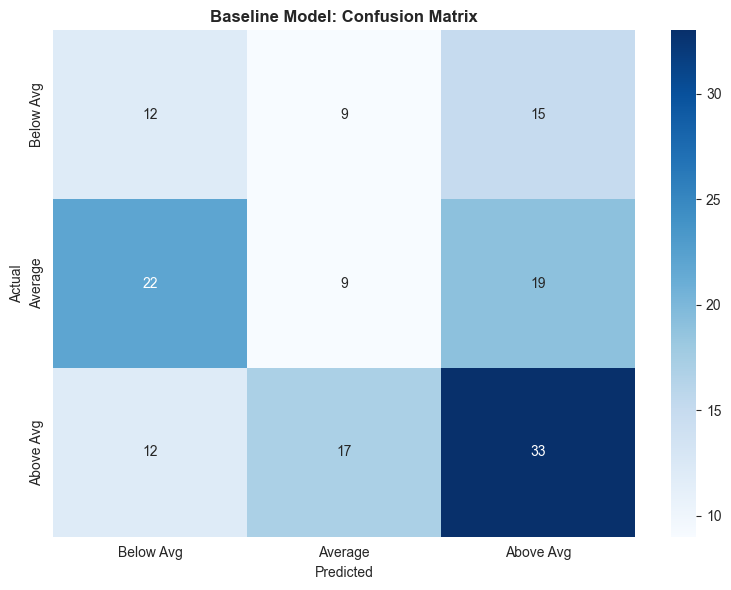


✓ Baseline model trained and evaluated


In [12]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)
print(f"\nClass weights: {class_weight_dict}")

# Train Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    solver='lbfgs'
)

lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)

# Evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_macro_lr = f1_score(y_test, y_pred_lr, average='macro')
f1_weighted_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\nBaseline Model Performance:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  F1 Score (macro): {f1_macro_lr:.4f}")
print(f"  F1 Score (weighted): {f1_weighted_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Below Average', 'Average', 'Above Average']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Below Avg', 'Average', 'Above Avg'],
            yticklabels=['Below Avg', 'Average', 'Above Avg'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Baseline Model: Confusion Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Baseline model trained and evaluated")

## 9. Production Models (Gradient Boosting)

In [13]:
print("="*80)
print("PRODUCTION MODELS: GRADIENT BOOSTING")
print("="*80)

models = {}
results = []

# 1. LightGBM
print("\n1. Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
f1_macro_lgb = f1_score(y_test, y_pred_lgb, average='macro')
f1_weighted_lgb = f1_score(y_test, y_pred_lgb, average='weighted')

results.append({
    'model': 'LightGBM',
    'accuracy': accuracy_lgb,
    'f1_macro': f1_macro_lgb,
    'f1_weighted': f1_weighted_lgb
})

print(f"   Accuracy: {accuracy_lgb:.4f}, F1 (macro): {f1_macro_lgb:.4f}")

# 2. XGBoost
print("\n2. Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Compute sample weights for XGBoost
sample_weights = np.array([class_weight_dict[y] for y in y_train])
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
models['XGBoost'] = xgb_model

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1_weighted_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

results.append({
    'model': 'XGBoost',
    'accuracy': accuracy_xgb,
    'f1_macro': f1_macro_xgb,
    'f1_weighted': f1_weighted_xgb
})

print(f"   Accuracy: {accuracy_xgb:.4f}, F1 (macro): {f1_macro_xgb:.4f}")

# 3. CatBoost (if available)
if CATBOOST_AVAILABLE:
    print("\n3. Training CatBoost...")
    cb_model = cb.CatBoostClassifier(
        iterations=300,
        depth=7,
        learning_rate=0.1,
        class_weights=class_weight_dict,
        random_state=42,
        verbose=False
    )
    
    cb_model.fit(X_train, y_train)
    models['CatBoost'] = cb_model
    
    y_pred_cb = cb_model.predict(X_test)
    y_pred_proba_cb = cb_model.predict_proba(X_test)
    
    accuracy_cb = accuracy_score(y_test, y_pred_cb)
    f1_macro_cb = f1_score(y_test, y_pred_cb, average='macro')
    f1_weighted_cb = f1_score(y_test, y_pred_cb, average='weighted')
    
    results.append({
        'model': 'CatBoost',
        'accuracy': accuracy_cb,
        'f1_macro': f1_macro_cb,
        'f1_weighted': f1_weighted_cb
    })
    
    print(f"   Accuracy: {accuracy_cb:.4f}, F1 (macro): {f1_macro_cb:.4f}")
else:
    print("\n3. CatBoost skipped (not available)")

# 4. Random Forest (for comparison)
print("\n4. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted')

results.append({
    'model': 'Random Forest',
    'accuracy': accuracy_rf,
    'f1_macro': f1_macro_rf,
    'f1_weighted': f1_weighted_rf
})

print(f"   Accuracy: {accuracy_rf:.4f}, F1 (macro): {f1_macro_rf:.4f}")

print("\n✓ All production models trained")

PRODUCTION MODELS: GRADIENT BOOSTING

1. Training LightGBM...
   Accuracy: 0.4324, F1 (macro): 0.4011

2. Training XGBoost...
   Accuracy: 0.4932, F1 (macro): 0.4604

3. Training CatBoost...
   Accuracy: 0.4932, F1 (macro): 0.4641

4. Training Random Forest...
   Accuracy: 0.4662, F1 (macro): 0.4492

✓ All production models trained


MODEL COMPARISON
              model  accuracy  f1_macro  f1_weighted
           CatBoost  0.493243  0.464086     0.483428
            XGBoost  0.493243  0.460354     0.481247
      Random Forest  0.466216  0.449150     0.460529
           LightGBM  0.432432  0.401116     0.421308
Logistic Regression  0.364865  0.338692     0.357066


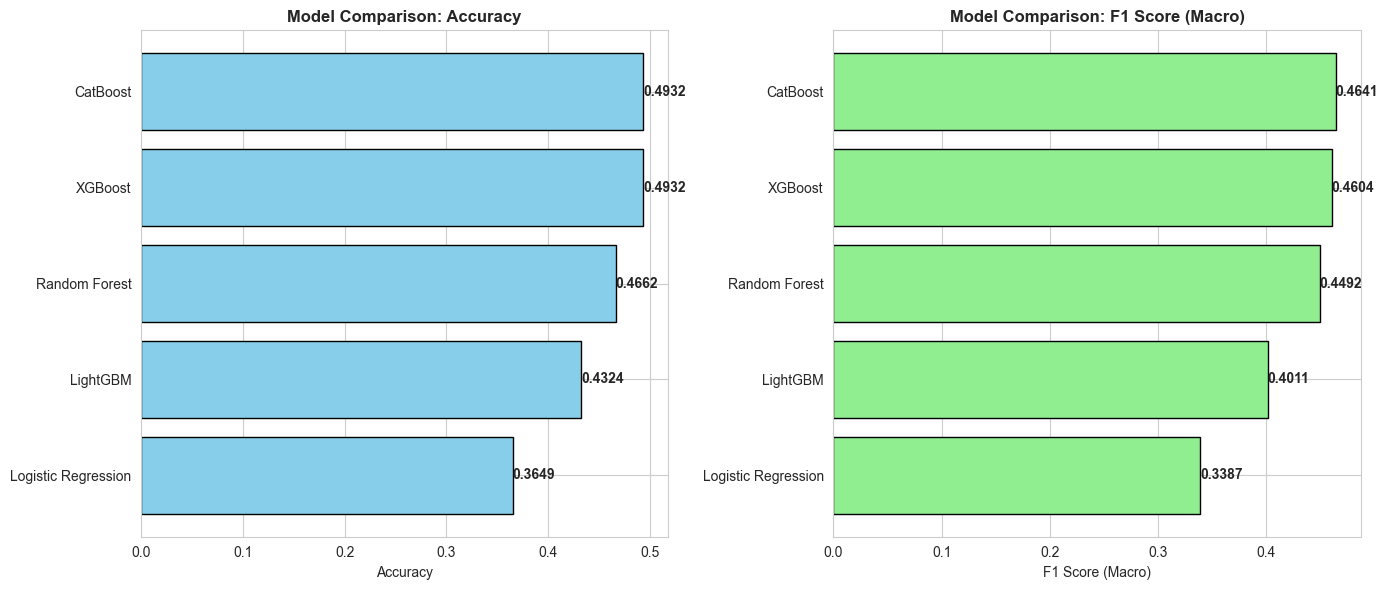


✓ Best model: CatBoost
  Accuracy: 0.4932
  F1 (macro): 0.4641


In [14]:
# Add baseline to results
results.append({
    'model': 'Logistic Regression',
    'accuracy': accuracy_lr,
    'f1_macro': f1_macro_lr,
    'f1_weighted': f1_weighted_lr
})

# Create comparison DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('f1_macro', ascending=False)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(df_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
axes[0].barh(df_results['model'], df_results['accuracy'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Comparison: Accuracy', fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(df_results['accuracy']):
    axes[0].text(v, i, f'{v:.4f}', va='center', ha='left', fontweight='bold')

# F1 Macro comparison
axes[1].barh(df_results['model'], df_results['f1_macro'], color='lightgreen', edgecolor='black')
axes[1].set_xlabel('F1 Score (Macro)')
axes[1].set_title('Model Comparison: F1 Score (Macro)', fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(df_results['f1_macro']):
    axes[1].text(v, i, f'{v:.4f}', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = df_results.iloc[0]['model']
best_model = models[best_model_name] if best_model_name in models else lr

print(f"\n✓ Best model: {best_model_name}")
print(f"  Accuracy: {df_results.iloc[0]['accuracy']:.4f}")
print(f"  F1 (macro): {df_results.iloc[0]['f1_macro']:.4f}")

## 11. Detailed Evaluation (Best Model)

DETAILED EVALUATION: CatBoost

Confusion Matrix:
[[14  6 16]
 [15 17 18]
 [ 8 12 42]]

Classification Report:
               precision    recall  f1-score   support

Below Average       0.38      0.39      0.38        36
      Average       0.49      0.34      0.40        50
Above Average       0.55      0.68      0.61        62

     accuracy                           0.49       148
    macro avg       0.47      0.47      0.46       148
 weighted avg       0.49      0.49      0.48       148


ROC-AUC (One-vs-Rest, macro): 0.6580


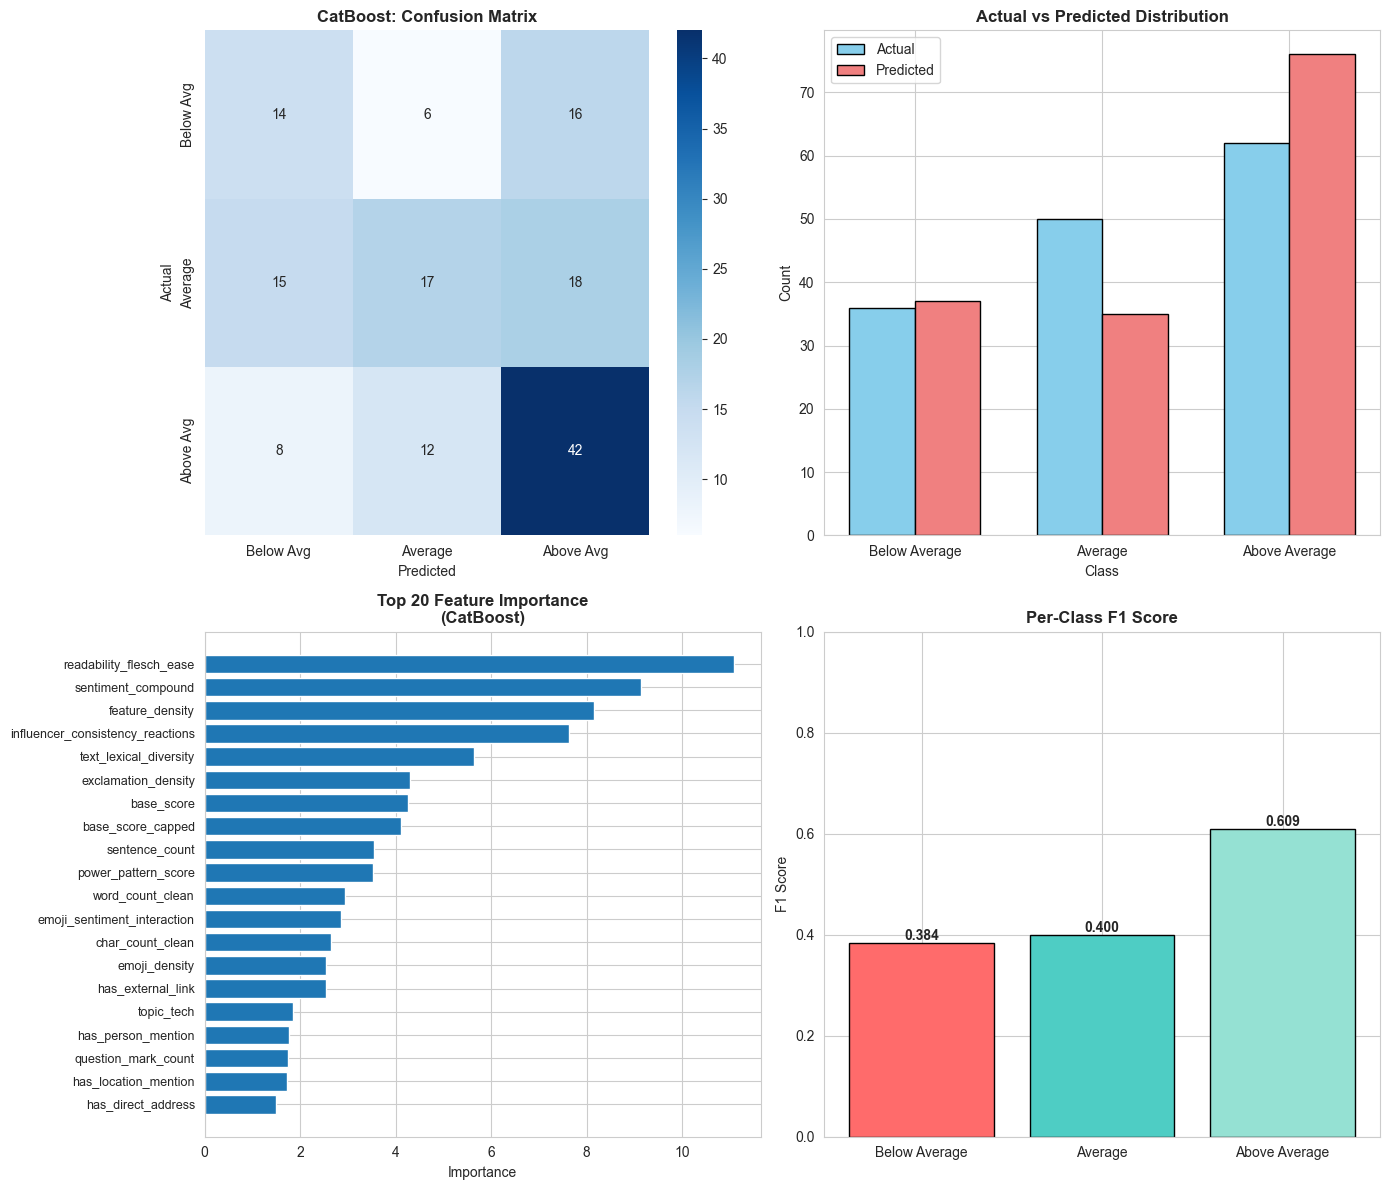


✓ Detailed evaluation complete


: 

In [ ]:
# Get predictions from best model
if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
elif best_model_name == 'LightGBM':
    y_pred_best = y_pred_lgb
    y_pred_proba_best = y_pred_proba_lgb
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb
elif best_model_name == 'CatBoost':
    y_pred_best = y_pred_cb
    y_pred_proba_best = y_pred_proba_cb
else:
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf

# Ensure predictions are 1D (some models return shape (n, 1))
y_pred_best = np.asarray(y_pred_best).ravel()

print("="*80)
print(f"DETAILED EVALUATION: {best_model_name}")
print("="*80)

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm_best)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Below Average', 'Average', 'Above Average']))

# ROC-AUC (one-vs-rest for multiclass)
try:
    roc_auc_ovr = roc_auc_score(y_test, y_pred_proba_best, multi_class='ovr', average='macro')
    print(f"\nROC-AUC (One-vs-Rest, macro): {roc_auc_ovr:.4f}")
except Exception as e:
    print(f"\nROC-AUC calculation failed: {e}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Below Avg', 'Average', 'Above Avg'],
            yticklabels=['Below Avg', 'Average', 'Above Avg'])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title(f'{best_model_name}: Confusion Matrix', fontweight='bold')

# Class distribution comparison
class_names = ['Below Average', 'Average', 'Above Average']
actual_counts = pd.Series(y_test).value_counts().sort_index()
predicted_counts = pd.Series(y_pred_best).value_counts().sort_index()

x = np.arange(len(class_names))
width = 0.35
axes[0, 1].bar(x - width/2, actual_counts.values, width, label='Actual', color='skyblue', edgecolor='black')
axes[0, 1].bar(x + width/2, predicted_counts.values, width, label='Predicted', color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Actual vs Predicted Distribution', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(class_names)
axes[0, 1].legend()

# Feature Importance (if tree-based model)
if best_model_name in ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest']:
    if hasattr(best_model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': selected_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        top20 = importances.head(20).iloc[::-1]
        axes[1, 0].barh(range(len(top20)), top20['importance'])
        axes[1, 0].set_yticks(range(len(top20)))
        axes[1, 0].set_yticklabels(top20['feature'], fontsize=9)
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_title(f'Top 20 Feature Importance\n({best_model_name})', fontweight='bold')

# Per-class performance
per_class_f1 = []
for i in range(3):
    f1 = f1_score(y_test == i, y_pred_best == i)
    per_class_f1.append(f1)

axes[1, 1].bar(class_names, per_class_f1, color=['#ff6b6b', '#4ecdc4', '#95e1d3'], edgecolor='black')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Per-Class F1 Score', fontweight='bold')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(per_class_f1):
    axes[1, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Detailed evaluation complete")

In [ ]:
# SHAP values for model interpretation
# Note: SHAP can be slow for large datasets, so we'll use a sample

print("="*80)
print("SHAP INTERPRETATION")
print("="*80)

# Only compute SHAP for tree-based models
if best_model_name in ['LightGBM', 'XGBoost', 'CatBoost', 'Random Forest']:
    print(f"\nComputing SHAP values for {best_model_name}...")
    print("  (Using sample of 100 instances for faster computation)")
    
    # Sample data for SHAP (faster computation)
    sample_size = min(100, len(X_test))
    sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
    X_sample = X_test.iloc[sample_idx] if isinstance(X_test, pd.DataFrame) else X_test[sample_idx]
    
    try:
        # Create SHAP explainer
        if best_model_name == 'LightGBM':
            explainer = shap.TreeExplainer(best_model)
        elif best_model_name == 'XGBoost':
            explainer = shap.TreeExplainer(best_model)
        elif best_model_name == 'CatBoost':
            explainer = shap.TreeExplainer(best_model)
        else:  # Random Forest
            explainer = shap.TreeExplainer(best_model)
        
        shap_values = explainer.shap_values(X_sample)
        
        # For multiclass, shap_values is a list
        if isinstance(shap_values, list):
            # Use class 2 (Above Average) for interpretation
            shap_values_class2 = shap_values[2]
        else:
            shap_values_class2 = shap_values
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_class2, X_sample, 
                         feature_names=selected_features, 
                         max_display=20, show=False)
        plt.title(f'SHAP Summary Plot ({best_model_name}) - Class 2 (Above Average)', 
                 fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Feature importance from SHAP
        shap_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': np.abs(shap_values_class2).mean(axis=0)
        }).sort_values('importance', ascending=False)
        
        print("\nTop 15 Features by SHAP Importance:")
        print(shap_importance.head(15).to_string(index=False))
        
        print("\n✓ SHAP interpretation complete")
        
    except Exception as e:
        print(f"\n⚠️  SHAP computation failed: {e}")
        print("  This is okay - feature importance from model is still available")
else:
    print(f"\n⚠️  SHAP not available for {best_model_name}")
    print("  SHAP works best with tree-based models (LightGBM, XGBoost, CatBoost, Random Forest)")

## 13. Cross-Validation (GroupKFold)

CROSS-VALIDATION (GroupKFold by Influencer)

Cross-validating CatBoost...
  Fold 1: Accuracy=0.4258, F1 (macro)=0.3925
  Fold 2: Accuracy=0.4194, F1 (macro)=0.3989
  Fold 3: Accuracy=0.4416, F1 (macro)=0.4134
  Fold 4: Accuracy=0.3961, F1 (macro)=0.3665
  Fold 5: Accuracy=0.4545, F1 (macro)=0.4373

Cross-Validation Results:
  Mean Accuracy: 0.4275 (+/- 0.0398)
  Mean F1 (macro): 0.4017 (+/- 0.0468)


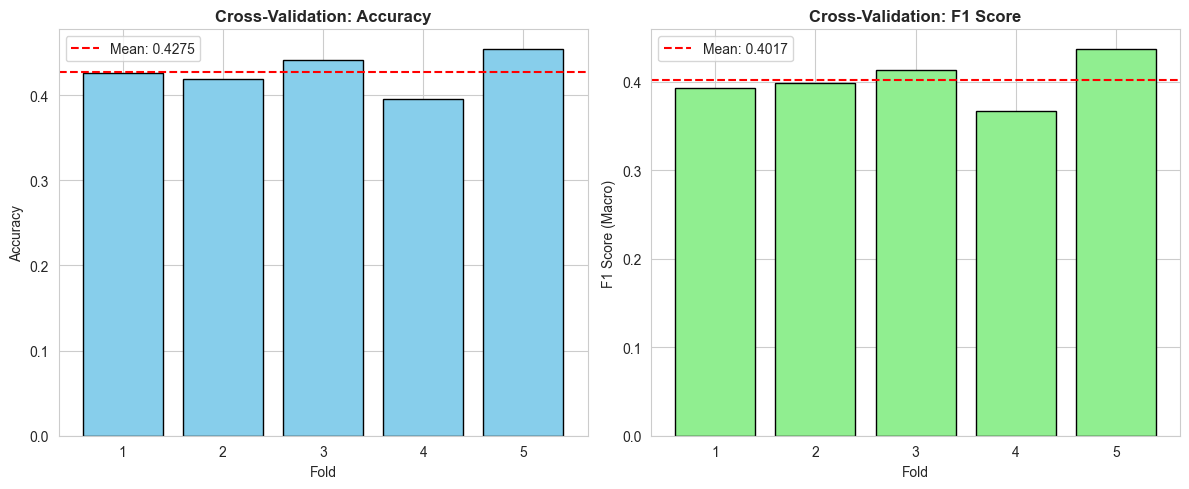


✓ Cross-validation complete


In [ ]:
# Cross-validation using GroupKFold to prevent data leakage
print("="*80)
print("CROSS-VALIDATION (GroupKFold by Influencer)")
print("="*80)

# Use full dataset for CV
X_full = X
y_full = y
groups_full = groups

# GroupKFold with 5 folds
gkf = GroupKFold(n_splits=5)

cv_scores = []
cv_f1_scores = []

print(f"\nCross-validating {best_model_name}...")

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_full, y_full, groups_full), 1):
    X_train_cv, X_val_cv = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_cv, y_val_cv = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    # Train model
    if best_model_name == 'Logistic Regression':
        model_cv = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            solver='lbfgs'
        )
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_cv.transform(X_val_cv)
        model_cv.fit(X_train_cv_scaled, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv_scaled)
    elif best_model_name == 'LightGBM':
        model_cv = lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    elif best_model_name == 'XGBoost':
        sample_weights_cv = np.array([class_weight_dict[y] for y in y_train_cv])
        model_cv = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        )
        model_cv.fit(X_train_cv, y_train_cv, sample_weight=sample_weights_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    elif best_model_name == 'CatBoost' and CATBOOST_AVAILABLE:
        model_cv = cb.CatBoostClassifier(
            iterations=300,
            depth=7,
            learning_rate=0.1,
            class_weights=class_weight_dict,
            random_state=42,
            verbose=False
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    else:  # Random Forest
        model_cv = RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict(X_val_cv)
    
    # Evaluate
    accuracy_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_macro_cv = f1_score(y_val_cv, y_pred_cv, average='macro')
    
    cv_scores.append(accuracy_cv)
    cv_f1_scores.append(f1_macro_cv)
    
    print(f"  Fold {fold}: Accuracy={accuracy_cv:.4f}, F1 (macro)={f1_macro_cv:.4f}")

print(f"\nCross-Validation Results:")
print(f"  Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
print(f"  Mean F1 (macro): {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores)*2:.4f})")

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
axes[0].axhline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Cross-Validation: Accuracy', fontweight='bold')
axes[0].legend()
axes[0].set_xticks(range(1, 6))

axes[1].bar(range(1, 6), cv_f1_scores, color='lightgreen', edgecolor='black')
axes[1].axhline(np.mean(cv_f1_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_f1_scores):.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('F1 Score (Macro)')
axes[1].set_title('Cross-Validation: F1 Score', fontweight='bold')
axes[1].legend()
axes[1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

print("\n✓ Cross-validation complete")

## 14. Save Final Model

In [ ]:
# Save model and metadata
import os
from datetime import datetime

MODEL_DIR = '../models_classification/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model
if best_model_name == 'Logistic Regression':
    joblib.dump(best_model, f'{MODEL_DIR}classification_model.pkl')
    joblib.dump(scaler, f'{MODEL_DIR}feature_scaler.pkl')
else:
    joblib.dump(best_model, f'{MODEL_DIR}classification_model.pkl')

# Save feature names
with open(f'{MODEL_DIR}feature_names.json', 'w') as f:
    json.dump({
        'features': selected_features,
        'n_features': len(selected_features),
        'model_type': best_model_name
    }, f, indent=2)

# Save metadata
metadata = {
    'version': '1.0',
    'model_type': '3-Class Classification',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'dataset': {
        'total_samples': len(df_clean),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': len(selected_features),
        'n_influencers': len(np.unique(groups))
    },
    'target_classes': {
        '0': 'Below Average',
        '1': 'Average',
        '2': 'Above Average'
    },
    'performance': {
        'accuracy': float(df_results.iloc[0]['accuracy']),
        'f1_macro': float(df_results.iloc[0]['f1_macro']),
        'f1_weighted': float(df_results.iloc[0]['f1_weighted']),
        'cv_accuracy_mean': float(np.mean(cv_scores)),
        'cv_accuracy_std': float(np.std(cv_scores)),
        'cv_f1_mean': float(np.mean(cv_f1_scores)),
        'cv_f1_std': float(np.std(cv_f1_scores))
    },
    'class_distribution': {
        'train': y_train.value_counts().to_dict(),
        'test': y_test.value_counts().to_dict()
    }
}

with open(f'{MODEL_DIR}model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("="*80)
print("MODEL SAVED")
print("="*80)
print(f"\nSaved to: {MODEL_DIR}")
print(f"  - classification_model.pkl ({best_model_name})")
if best_model_name == 'Logistic Regression':
    print(f"  - feature_scaler.pkl")
print(f"  - feature_names.json")
print(f"  - model_metadata.json")

print("\n" + "="*80)
print("CLASSIFICATION MODEL TRAINING COMPLETE")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"  Test Accuracy: {df_results.iloc[0]['accuracy']:.4f}")
print(f"  Test F1 (macro): {df_results.iloc[0]['f1_macro']:.4f}")
print(f"  CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")
print(f"  CV F1 (macro): {np.mean(cv_f1_scores):.4f} (+/- {np.std(cv_f1_scores)*2:.4f})")
print("\n✓ Model ready for deployment!")

MODEL SAVED

Saved to: ../models_classification/
  - classification_model.pkl (CatBoost)
  - feature_names.json
  - model_metadata.json

CLASSIFICATION MODEL TRAINING COMPLETE

Best Model: CatBoost
  Test Accuracy: 0.4932
  Test F1 (macro): 0.4641
  CV Accuracy: 0.4275 (+/- 0.0398)
  CV F1 (macro): 0.4017 (+/- 0.0468)

✓ Model ready for deployment!
